In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

In [2]:
ids = pd.read_csv("scale_data/scaledata/Dennis+Schwartz/id.Dennis+Schwartz.txt", sep="[\r\n]+", header=None, names=["id"])
label_3class = pd.read_csv("scale_data/scaledata/Dennis+Schwartz/label.3class.Dennis+Schwartz.txt", sep="[\r\n]+", names=["3class_label"])
label_4class = pd.read_csv("scale_data/scaledata/Dennis+Schwartz/label.4class.Dennis+Schwartz.txt", sep="[\r\n]+",names=["4class_label"])
rating = pd.read_csv("scale_data/scaledata/Dennis+Schwartz/rating.Dennis+Schwartz.txt", sep="[\r\n]+",names=["rating"])
subj = pd.read_csv("scale_data/scaledata/Dennis+Schwartz/subj.Dennis+Schwartz.txt", sep="[\r\n]+",names=["subj_extraction"])

/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.
/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  
/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support 

In [3]:
dennis = pd.concat([ids,label_3class, label_4class, rating, subj], axis = 1)

In [4]:
dennis.head(5)

,id,3class_label,4class_label,rating,subj_extraction
0,29420,0,0,0.1,"in my opinion , a movie reviewer's most import..."
1,17219,0,0,0.2,"you can watch this movie , that is based on a ..."
2,18406,0,0,0.2,"this is asking a lot to believe , and though i..."
3,18648,0,0,0.2,no heroes and no story are the main attributes...
4,20021,0,0,0.2,"this is not an art movie , yet i saw it an art..."


In [5]:
dennis["strongly neg"]=dennis.apply(lambda x:x["4class_label"]==0, axis=1)
dennis["neg"]=dennis.apply(lambda x:x["4class_label"]==1, axis=1)
dennis["pos"]=dennis.apply(lambda x:x["4class_label"]==2, axis=1)
dennis["strongly pos"]=dennis.apply(lambda x:x["4class_label"]==3, axis=1)

In [6]:
y_d = dennis['3class_label']
dennis['n']=dennis.apply(lambda x:x["4class_label"]==0, axis=1)
dennis["neg"]=dennis.apply(lambda x:x["4class_label"]==1, axis=1)
dennis["pos"]=dennis.apply(lambda x:x["4class_label"]==2, axis=1)
y_d_encode = dennis[['n', 'neg', 'pos']]

In [7]:
from sklearn.model_selection import train_test_split
xtrain_d, xvalid_d, ytrain_d, yvalid_d = train_test_split(dennis['subj_extraction'], y_d, 
                                                  stratify=y_d, 
                                                  random_state=42, 
                                                  test_size=0.1, shuffle=True)

In [8]:
xtrain_d, xvalid_d, ytrain_d_encode, yvalid_d_encode = train_test_split(dennis['subj_extraction'], y_d_encode, 
                                                  stratify=y_d, 
                                                  random_state=42, 
                                                  test_size=0.1, shuffle=True)

In [9]:
ytrain_d_encode

,n,neg,pos
86,True,False,False
124,True,False,False
347,False,True,False
413,False,True,False
630,False,False,True
974,False,False,False
709,False,False,True
807,False,False,True
384,False,True,False
110,True,False,False


In [10]:
xtrain_d.head(5)

86     it is a call for artistic freedom , but intere...
124    steal this movie ! it meant well , showing the...
347    a rather flat film noir that never gets that i...
413    takeshi " beat " kitano is certainly a unique ...
630    as the one giving the orders , the big boss , ...
Name: subj_extraction, dtype: object

## Loss Function

In [11]:
def multiclass_logloss(actual, predicted, eps=1e-15):
    """Multi class version of Logarithmic Loss metric.
    :param actual: Array containing the actual target classes
    :param predicted: Matrix with class predictions, one probability per class
    """
    # Convert 'actual' to a binary array if it's not already:
    if len(actual.shape) == 1:
        actual2 = np.zeros((actual.shape[0], predicted.shape[1]))
        for i, val in enumerate(actual):
            actual2[i, val] = 1
        actual = actual2

    clip = np.clip(predicted, eps, 1 - eps)
    rows = actual.shape[0]
    vsota = np.sum(actual * np.log(clip))
    return -1.0 / rows * vsota

In [12]:
loss = []

## TF-IDF

In [13]:
# Always start with these features. They work (almost) everytime!
tfv = TfidfVectorizer(min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

# Fitting TF-IDF to both training and test sets (semi-supervised learning)
tfv.fit(list(xtrain_d) + list(xvalid_d))
xtrain_d_tfv =  tfv.transform(xtrain_d) 
xvalid_d_tfv = tfv.transform(xvalid_d)

In [14]:
print (xtrain_d.shape)
xtrain_d_tfv.shape
# for t in xtrain_d_tfv:
#     print (t)
#     break

(924,)


(924, 10512)

## Logistic regression

In [15]:
# Fitting a simple Logistic Regression on TFIDF
clf_l_t = LogisticRegression(C=1.0)
clf_l_t.fit(xtrain_d_tfv, ytrain_d)
predictions = clf_l_t.predict_proba(xvalid_d_tfv)

print ("logloss: %0.3f " % multiclass_logloss(yvalid_d, predictions))

logloss: 0.935 


In [16]:
loss_d_t_l = 0.935

## Fitting a simple Naive Bayes on TFIDF

In [17]:
# Fitting a simple Naive Bayes on TFIDF
clf_n_t = MultinomialNB()
clf_n_t.fit(xtrain_d_tfv, ytrain_d)
predictions = clf_n_t.predict_proba(xvalid_d_tfv)

print ("logloss: %0.3f " % multiclass_logloss(yvalid_d, predictions))

logloss: 0.938 


In [18]:
loss_d_t_n = 0.938

## fitting SVM on tfidf

In [17]:
# Fitting a simple Naive Bayes on TFIDF
clf_s_t = SVC(probability=True, kernel = 'rbf')
clf_s_t.fit(xtrain_d_tfv, ytrain_d)
predictions = clf_s_t.predict_proba(xvalid_d_tfv)

print ("logloss: %0.3f " % multiclass_logloss(yvalid_d, predictions))

logloss: 0.775 


## a three layer neural network

In [19]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder
import time
from keras import metrics
print('import done')

Using TensorFlow backend.


import done


In [20]:
print (xtrain_d_tfv.shape, ytrain_d.shape)
le = LabelEncoder()
ytrain_d_encode = le.fit_transform(ytrain_d)

(924, 10512) (924,)


In [26]:
num_max = 10512
def model_3_layer():
    model = Sequential()
    model.add(Dense(512, activation = 'relu', input_shape=(num_max,)))
    model.add(Dropout(0.2))
    model.add(Dense(256, activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation = 'sigmoid'))
    model.summary()
#     model.compile(optimizer='rmsprop', 
#                   loss='categorical_crossentropy',
#                   metrics=['accuracy'])
    model.compile(optimizer='rmsprop', 
              loss='binary_crossentropy',
              metrics=['accuracy'])
    print ('compile done')
    return model

def fit_model(model, X, y):
    model.fit(X,y,batch_size=32,epochs=10,verbose=1,validation_split=0.2)

In [27]:
model = model_3_layer()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 512)               5382656   
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 257       
Total params: 5,514,241
Trainable params: 5,514,241
Non-trainable params: 0
_________________________________________________________________
compile done


In [28]:
ytrain_d_encode[:10]

array([0, 0, 0, 1, 1, 2, 1, 2, 1, 0])

In [29]:
fit_model(model, xtrain_d_tfv, ytrain_d_encode)

Train on 739 samples, validate on 185 samples
Epoch 1/10
739/739 [==============================] - 4s 5ms/step - loss: 0.2264 - acc: 0.4100 - val_loss: -0.3214 - val_acc: 0.4054
Epoch 2/10
739/739 [==============================] - 2s 3ms/step - loss: -2.0203 - acc: 0.5453 - val_loss: -1.9906 - val_acc: 0.4541
Epoch 3/10
739/739 [==============================] - 3s 3ms/step - loss: -3.4843 - acc: 0.7429 - val_loss: -2.2054 - val_acc: 0.5243
Epoch 4/10
739/739 [==============================] - 3s 4ms/step - loss: -3.6420 - acc: 0.7659 - val_loss: -2.2985 - val_acc: 0.5405
Epoch 5/10
739/739 [==============================] - 3s 4ms/step - loss: -3.6616 - acc: 0.7700 - val_loss: -2.2505 - val_acc: 0.5405
Epoch 6/10
739/739 [==============================] - 3s 3ms/step - loss: -3.6660 - acc: 0.7700 - val_loss: -2.2363 - val_acc: 0.5459
Epoch 7/10
739/739 [==============================] - 3s 4ms/step - loss: -3.6673 - acc: 0.7700 - val_loss: -2.2848 - val_acc: 0.5405
Epoch 8/10
739/73

In [30]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


## Word count model

In [18]:
ctv = CountVectorizer(analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), stop_words = 'english')

# Fitting Count Vectorizer to both training and test sets (semi-supervised learning)
ctv.fit(list(xtrain_d) + list(xvalid_d))
xtrain_d_ctv =  ctv.transform(xtrain_d) 
xvalid_d_ctv = ctv.transform(xvalid_d)

In [19]:
xtrain_d_ctv.shape

(924, 255418)

## Fitting a simple logistic regression on word count

In [20]:
# Fitting a simple Logistic Regression on word Counts
clf_l_w = LogisticRegression(C=1.0)
clf_l_w.fit(xtrain_d_ctv, ytrain_d)
predictions = clf_l_w.predict_proba(xvalid_d_ctv)

print ("logloss: %0.3f " % multiclass_logloss(yvalid_d, predictions))

logloss: 0.735 


## Fitting a simple naive bayes on word count
Why do we use NB for text classification?
1. the tfidf matrix is sparse, though not independent.
2. We can treat tf-idf value as categorical


In [21]:
# Fitting a simple Naive Bayes on word count
clf_n_w = MultinomialNB()
clf_n_w.fit(xtrain_d_ctv, ytrain_d)
predictions = clf_n_w.predict_proba(xvalid_d_ctv)

print ("logloss: %0.3f " % multiclass_logloss(yvalid_d, predictions))

logloss: 2.655 


In [22]:
loss_d_w_n = 2.655

## fitting SVM on word count

In [23]:
# Fitting a simple Naive Bayes on word count
clf_s_w = SVC(probability=True, kernel = 'rbf')
clf_s_w.fit(xtrain_d_ctv, ytrain_d)
predictions = clf_s_w.predict_proba(xvalid_d_ctv)

print ("logloss: %0.3f " % multiclass_logloss(yvalid_d, predictions))

logloss: 0.973 


## Glove model

In [24]:
import os
import zipfile
import pandas as pd
import numpy as np
import csv
import gensim

In [25]:
pre_trained=True
GLOVE_PATH = os.path.dirname(os.getcwd()) + '/models/glove.840B.300d.zip'
GLOVE_FILE = 'glove.840B.300d.txt'  # can change it to glove.6B.50d.txt, glove.6B.100d.txt, glove.6B.200d.txt
# load the file
if pre_trained:
    glove = zipfile.ZipFile(GLOVE_PATH, 'r')
    words = pd.read_table(glove.open(GLOVE_FILE), sep=" ", index_col=0, header=None, quoting=csv.QUOTE_NONE)
    model = words.as_matrix()
else:
    model = None
# build dictionary
if model is not None:
    dict1 = {word: i for i, word in enumerate(words.index)}
else:
    dict1 = {}

In [30]:
def sentence_vectorize(s):
    words = str(s).lower()
#     words = word_tokenize(words)
#     words = [w for w in words if not w in stop_words]
#     words = [w for w in words if w.isalpha()]
    M = []
    for w in s:
        try:
            M.append(embeddings_index[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(300)
    return v / np.sqrt((v ** 2).sum())

In [39]:
xtrain_d_glv = [sentence_vectorize(sent) for sent in xtrain_d]
xvalid_d_glv = [sentence_vectorize(sent) for sent in xvalid_d]

In [40]:
xtrain_d_glv = np.array(xtrain_d_glv)
xvalid_d_glv = np.array(xvalid_d_glv)

In [67]:
xtrain_d_glv

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

## Glove on Logistic regression

In [92]:
clf_l_g = LogisticRegression(C=1.0)
clf_l_g.fit(xtrain_d_glv, ytrain_d)
predictions = clf_l_g.predict_proba(xvalid_d_glv)

print ("logloss: %0.3f " % multiclass_logloss(yvalid_d, predictions))

logloss: 1.072 


In [62]:
pre_g_d = predictions

## Glove on Naive Bayes

In [93]:
clf_n_g = MultinomialNB()
clf_n_g.fit(xtrain_d_glv, ytrain_d)
predictions = clf_n_g.predict_proba(xvalid_d_glv)
print ("logloss: %0.3f " % multiclass_logloss(yvalid_d, predictions))

logloss: 1.072 


# Test models above on other writers

In [35]:
ids = pd.read_csv("scale_data/scaledata/James+Berardinelli/id.James+Berardinelli.txt", sep="[\r\n]+", header=None, names=["id"])
# label_3class = pd.read_csv("scale_data/scaledata/James+Berardinelli/label.3class.James+Berardinelli.txt", sep="[\r\n]+", names=["3class_label"])
label_3class = pd.read_csv("scale_data/scaledata/James+Berardinelli/label.3class.James+Berardinelli.txt", sep="[\r\n]+",names=["3class_label"])

label_4class = pd.read_csv("scale_data/scaledata/James+Berardinelli/label.4class.James+Berardinelli.txt", sep="[\r\n]+",names=["4class_label"])
rating = pd.read_csv("scale_data/scaledata/James+Berardinelli/rating.James+Berardinelli.txt", sep="[\r\n]+",names=["rating"])
subj = pd.read_csv("scale_data/scaledata/James+Berardinelli/subj.James+Berardinelli.txt", sep="[\r\n]+",names=["subj_extraction"])

/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.
/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: ParserWarnin

In [36]:
james = pd.concat([ids,label_3class, label_4class, rating, subj], axis = 1)
james.head(5)

,id,3class_label,4class_label,rating,subj_extraction
0,2321,0,0,0.05,i didn't expect ghost in the machine to be thi...
1,3337,0,0,0.05,"admittedly , with a title like the mangler , y..."
2,6511,0,0,0.05,"cast : christopher lambert , natasha henstridg..."
3,6912,0,0,0.05,"inevitably , someone is going to ask me why i ..."
4,2240,0,0,0.09,ernest : the one-joke concept that refuses to ...


In [37]:
y_j = james['3class_label']

In [38]:
xtrain_j, xvalid_j, ytrain_j, yvalid_j = train_test_split(james.subj_extraction.values, y_j, 
                                                  stratify=y_j, 
                                                  random_state=42, 
                                                  test_size=0.1, shuffle=True)

## tf-idf model

In [39]:
# Always start with these features. They work (almost) everytime!
tfv = TfidfVectorizer(min_df=3,  max_features=10512, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

# Fitting TF-IDF to both training and test sets (semi-supervised learning)
tfv.fit(list(xtrain_j) + list(xvalid_j))
xtrain_j_tfv =  tfv.transform(xtrain_j) 
xvalid_j_tfv = tfv.transform(xvalid_j)

In [40]:
xtrain_j_tfv.shape

(1176, 10512)

## Fitting a simple Logistic Regression on TFIDF

In [82]:
# Fitting a simple Logistic Regression on TFIDF

predictions = clf_l_t.predict_proba(xvalid_j_tfv)

print ("logloss: %0.3f " % multiclass_logloss(yvalid_j, predictions))

logloss: 1.183 


## Fitting a simple Naive Bayes on TFIDF

In [154]:
# Fitting a simple Naive Bayes on TFIDF
# clf_n_t = MultinomialNB()
clf_n_t.fit(xtrain_j_tfv, ytrain_j)
predictions = clf_n_t.predict_proba(xvalid_j_tfv)

print ("logloss: %0.3f " % multiclass_logloss(yvalid_j, predictions))

logloss: 0.816 


## fitting SVM on tfidf

In [45]:
# Fitting a simple SVM on TFIDF
# clf_s_t = SVC(probability=True, kernel = 'rbf')

predictions = clf_s_t.predict_proba(xvalid_j_tfv)

print ("logloss: %0.3f " % multiclass_logloss(yvalid_j, predictions))

logloss: 1.209 


## a three layer neural network

In [26]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder
import time
from keras import metrics
print('import done')

Using TensorFlow backend.


import done


## word count model

In [50]:
ctv = CountVectorizer(analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), stop_words = 'english', max_features = 255418)

# Fitting Count Vectorizer to both training and test sets (semi-supervised learning)
ctv.fit(list(xtrain_j) + list(xvalid_j))
xtrain_j_ctv =  ctv.transform(xtrain_j) 
xvalid_j_ctv = ctv.transform(xvalid_j)

In [51]:
xtrain_j_ctv.shape

(1176, 255418)

## Fitting a simple Logistic Regression on word Counts

In [88]:
# Fitting a simple Logistic Regression on word Counts
# clf = LogisticRegression(C=1.0)
# clf.fit(xtrain_j_ctv, ytrain_j)
predictions = clf_l_w.predict_proba(xvalid_j_ctv)

print ("logloss: %0.3f " % multiclass_logloss(yvalid_j, predictions))

logloss: 1.278 


## Fitting a simple Naive Bayes on wordcount

In [89]:
# Fitting a simple Naive Bayes on wordcount
# clf = MultinomialNB()
# clf.fit(xtrain_j_ctv, ytrain_j)
predictions = clf_n_w.predict_proba(xvalid_j_ctv)

print ("logloss: %0.3f " % multiclass_logloss(yvalid_j, predictions))

logloss: 10.194 


## Fitting a svm on wordcount

In [52]:
predictions = clf_s_w.predict_proba(xvalid_j_ctv)

print ("logloss: %0.3f " % multiclass_logloss(yvalid_j, predictions))

logloss: 1.448 


## Glove

In [91]:
xtrain_j_glv = [sentence_vectorize(sent) for sent in xtrain_j]
xvalid_j_glv = [sentence_vectorize(sent) for sent in xvalid_j]
xtrain_d_glv = np.array(xtrain_d_glv)
xvalid_d_glv = np.array(xvalid_d_glv)

## Fitting Logistic regression on glove

In [94]:
predictions = clf_l_g.predict_proba(xvalid_j_glv)

print ("logloss: %0.3f " % multiclass_logloss(yvalid_j, predictions))

logloss: 1.177 


## Fitting NB on glove

## data for scott

In [145]:
ids = pd.read_csv("scale_data/scaledata/Scott+Renshaw/id.Scott+Renshaw.txt", sep="[\r\n]+", header=None, names=["id"])
label_3class = pd.read_csv("scale_data/scaledata/Scott+Renshaw/label.3class.Scott+Renshaw.txt", sep="[\r\n]+", names=["3class_label"])
label_4class = pd.read_csv("scale_data/scaledata/Scott+Renshaw/label.4class.Scott+Renshaw.txt", sep="[\r\n]+",names=["4class_label"])
rating = pd.read_csv("scale_data/scaledata/Scott+Renshaw/rating.Scott+Renshaw.txt", sep="[\r\n]+",names=["rating"])
subj = pd.read_csv("scale_data/scaledata/Scott+Renshaw/subj.Scott+Renshaw.txt", sep="[\r\n]+",names=["subj_extraction"])

/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.
/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  
/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support 

In [146]:
scott = pd.concat([ids,label_3class, label_4class, rating, subj], axis = 1)
scott.head(5)

,id,3class_label,4class_label,rating,subj_extraction
0,11961,0,0,0.0,i'm guessing -- and from the available evidenc...
1,13915,0,0,0.0,"there's bad buzz , and then there's the the ba..."
2,2790,0,0,0.0,director : richard rush . director richard rus...
3,3285,0,0,0.0,screenplay : johnny brennan & kamal ahmed and ...
4,10264,0,0,0.1,screenplay : tim burns & tom stern and anthony...


In [149]:
y_s = james['3class_label']

In [150]:
xtrain_s, xvalid_s, ytrain_s, yvalid_s = train_test_split(james.subj_extraction.values, y_s, 
                                                  stratify=y_s, 
                                                  random_state=42, 
                                                  test_size=0.1, shuffle=True)

In [151]:
# Always start with these features. They work (almost) everytime!
# tfv = TfidfVectorizer(min_df=3,  max_features=10512, 
#             strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
#             ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
#             stop_words = 'english')

# Fitting TF-IDF to both training and test sets (semi-supervised learning)
tfv.fit(list(xtrain_s) + list(xvalid_s))
xtrain_s_tfv =  tfv.transform(xtrain_s) 
xvalid_s_tfv = tfv.transform(xvalid_s)

In [152]:
xtrain_s_tfv.shape

(1176, 10512)

In [153]:
predictions = clf_l_t.predict_proba(xvalid_s_tfv)

print ("logloss: %0.3f " % multiclass_logloss(yvalid_s, predictions))

logloss: 1.183 


In [155]:
predictions = clf_n_t.predict_proba(xvalid_s_tfv)

print ("logloss: %0.3f " % multiclass_logloss(yvalid_s, predictions))

logloss: 0.816 


In [158]:
ctv = CountVectorizer(analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), stop_words = 'english', max_features = 10512)


# Fitting Count Vectorizer to both training and test sets (semi-supervised learning)
ctv.fit(list(xtrain_s) + list(xvalid_s))
xtrain_s_ctv =  ctv.transform(xtrain_s) 
xvalid_s_ctv = ctv.transform(xvalid_s)

In [159]:

predictions = clf_l_w.predict_proba(xvalid_s_tfv)

print ("logloss: %0.3f " % multiclass_logloss(yvalid_s, predictions))

ValueError: X has 10512 features per sample; expecting 255418

In [95]:
predictions = clf_n_g.predict_proba(xvalid_j_glv)

print ("logloss: %0.3f " % multiclass_logloss(yvalid_j, predictions))

logloss: 1.178 


# Results

In [136]:
df = pd.read_csv('comparison_res.csv', delimiter = '\t')
df = df[['classifier', 'log-loss', 'writer']]
df

,classifier,log-loss,writer
0,l_tf,0.935,dennis
1,n_tf,0.938,dennis
2,l_w,0.735,dennis
3,n_w,2.655,dennis
4,l_g,1.072,dennis
5,n_g,1.072,dennis
6,l_tf,1.183,James
7,n_tf,0.919,James
8,l_w,1.278,James
9,n_w,10.194,James


writer
James     AxesSubplot(0.125,0.125;0.775x0.755)
dennis    AxesSubplot(0.125,0.125;0.775x0.755)
Name: log-loss, dtype: object

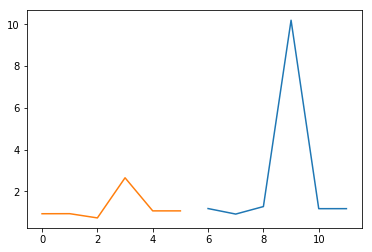

In [144]:
df.groupby('writer')['log-loss'].plot(kind = 'line')

In [ ]:
import matplotlib.pyplot as plt
plt.xlabel("classifier")
plt.ylabel('Log loss')
x = [0,1,2,3,4,5]
y_dennis = df[:6]["log-loss"]
y_james = df[6:]["log-loss"]
my_xticks = df[:6]["classifier"]
plt.xticks(x, my_xticks)
plt.plot(x, y_dennis)
plt.plot(x, y_james)
plt.legend(['Dennis', 'James'])
plt.show()
